# FIT simulations

### Little bit of theory:

**Transfer entropy**: the mutual information between $Y_{pres}$ and $X_{past}$, conditioned on $Y_{past}$

$$ TE(X\rightarrow Y) = I(X_{past}; Y_{pres}|Y_{past}) $$

where

$$ I(S=s,X_i) = \sum_{x_i \in X_i} p(x_i|s)\,\log\frac{p(s|x_i)}{p(s)}$$

is the specific information that the source $X_i$ carries about a specific outcome of the target variable $s\in S$.

**FIT**:

$$ FIT = \text{min}[SUI(S: X_{past}, Y_{pres} \ Y_{past} ),\, SUI(Y_{pres}: X_{past}, S\ Y_{past})] $$

where 
- $SUI(S: X_{past}, Y_{pres} \ Y_{past} )$ is the information about $S$ that $X_{past}$ shares with $Y_{pres}$ and it's unique with respect to $Y_{past}$ and it's defined as the difference between the shared information that $X_{past}, Y_{pres}$ carry about $S$ and the shared information that $X_{past}, Y_{pres}$ and $Y_{past}$ carry about $S$
- $SUI(Y_{pres}: X_{past}, S\ Y_{past})$ is the information about $Y_{pres}$ that $X_{past}$ shares with $S$ and it's unique with respect to $Y_{past}$

Moreover

$$ SUI(S:X_1,X_2) = \sum_{s\in S} p(s) \text{min}_{X_i \in \{ X_1, X_2\} } I(S=s,X_i) $$

is the shared information that $X_1$ and $X_2$ carry about $S$.

**Sender activity**: 2D variable

$$X(t)_{stim} = S(t)(1+N(0, \sigma_{stim}))$$

where $S(t)$ is a step function equal to the value of the stimulus $s \in [1,4]$ during the time window $[200,250]\,ms$.

$$X(t)_{noise} = N(0,\sigma)$$

**Receiver activity**: 1D variable

$$Y(t) = W_{stim}X_{stim}(t-\delta) + W_{noise}X_{noise}(t-\delta) + N(0,\sigma)$$

where the **delay** $\delta$ is chosen randomly from a uniform distribution in $[40,60]\,ms$ in step of $10\,ms$, moreover $\sigma = 2$ and $\sigma_{stim} = \sigma/5 = 0.4$.

**Numerical computation of FIT**: discretization of neural activity into a number R of equipopulated bins and empirical computation of the occurence frequency of each binned response across all available trials.

FIT/TE are computed at the first time instant in which $Y$ received information from $X$.

Total of 50 simulation with 500 trials per stimulus each one.

### WHAT TO DO

- **Fig. 2A**: evaluation of FIT and TE for each value of $W_{noise}$ and $W_{stim}$
- **Fig. 2B**: FIT and TE as a function of time with $W_{stim}=0.5$ and $W_{noise}=1$ (FIT/TE values computed at all points and averaged over delays to obtain temporal profiles of transmitted information)

In [18]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [19]:
#from compute_FIT_TE import get_joint_prob_distr, compute_FIT_TE_DFI

In [20]:
npr.seed(1)

Simulation parameters

In [21]:
nTrials_per_stim = 500      # number of trials for each simulation
simReps = 50                # number of simulations
nShuff = 10                 # number of permutations

w_sig = np.linspace(0, 1, num=10)      # signal weights for Y computation
w_noise = np.linspace(0, 1, num=10)    # noise weights for Y computation
stdX_noise = 2                      # std of gaussian noise in X_noise
stdY = 2                            # std of gaussian noise in Y
ratio = 0.2                         # ratio between stdX_sig and stdX_noise
stdX_sig = ratio * stdX_noise       # std of gaussian noise in X_signal

Global parameters

In [22]:
simLen = 60                             # simulation length in units of 10 ms
stimWin = [30, 35]                      # X stimulus encoding window in units of 10 ms
delays = np.linspace(4, 6, num=3, dtype=int)
n_binsS = 4                             # number of stimulus values
n_binsX = 3
n_binsY = 3
eps = 1e-52                             # infinitesimal value

nTrials = nTrials_per_stim * n_binsS

In [23]:
# Draw random delay for each simulation repetition
reps_delays = npr.choice(delays, simReps, replace=True)

Structures

In [24]:
fit = np.full(shape=(simReps, len(w_sig), len(w_noise)), fill_value=np.nan)
te = fit.copy()
dfi = fit.copy()
fitsh = np.full((simReps, len(w_sig), len(w_noise), nShuff), np.nan)
dish = fitsh.copy()
dfish = fitsh.copy()
fitsh_cond = np.full((simReps, len(w_sig), len(w_noise), nShuff), np.nan)
dish_cond = fitsh_cond.copy()
dfish_cond = fitsh_cond.copy()

In [25]:
np.shape(fit[0][0])

(10,)

### Utils functions (here only for debugging)

In [26]:
def get_SUI(joint_prob_distr):

    # get dimensions
    dim_x_past = joint_prob_distr.shape[0]
    dim_y_pres = joint_prob_distr.shape[1]
    dim_y_past = joint_prob_distr.shape[2]
    dim_s = joint_prob_distr.shape[3]

    # initialize arrays
    spec_surprise_x = np.zeros(dim_s)
    spec_surprise_y = np.zeros(dim_s)
    spec_surprise_y_past = np.zeros(dim_s)

    # compute specific information provided by each source variable about s (target)
    for s in range(dim_s):

        # p(s)
        ps = np.sum(joint_prob_distr[:, :, :, s]) 

        # info provided by x past
        for x in range(dim_x_past):
            psx = np.sum(joint_prob_distr[x, :, :, s]) / (np.sum(joint_prob_distr[x, :, :, :]) + np.finfo(float).eps)
            pxs = np.sum(joint_prob_distr[x, :, :, s]) / (np.sum(joint_prob_distr[:, :, :, s]) + np.finfo(float).eps)

            spec_surprise_x[s] += pxs * (np.log2(1/(ps + np.finfo(float).eps)) - np.log2(1/(psx + np.finfo(float).eps)))

        # info provided by y
        for y in range(dim_y_pres):
            psy = np.sum(joint_prob_distr[:, y, :, s]) / (np.sum(joint_prob_distr[:, y, :, :]) + np.finfo(float).eps)
            pys = np.sum(joint_prob_distr[:, y, :, s]) / (np.sum(joint_prob_distr[:, :, :, s]) + np.finfo(float).eps)
            
            spec_surprise_y[s] += pys * (np.log2(1/(ps + np.finfo(float).eps)) - np.log2(1/(psy + np.finfo(float).eps)))

        # info provided by y past
        for y in range(dim_y_past):
            psy = np.sum(joint_prob_distr[:, :, y, s]) / (np.sum(joint_prob_distr[:, :, y, :]) + np.finfo(float).eps)
            pys = np.sum(joint_prob_distr[:, :, y, s]) / (np.sum(joint_prob_distr[:, :, :, s]) + np.finfo(float).eps)
            
            spec_surprise_y_past[s] += pys * (np.log2(1/(ps + np.finfo(float).eps)) - np.log2(1/(psy + np.finfo(float).eps)))

    # compute IMin

    IMin_x_y_ypast = 0
    IMin_x_y = 0

    for s in range(dim_s):
        IMin_x_y_ypast += np.sum(joint_prob_distr[:, :, :, s]) * min(spec_surprise_x[s], spec_surprise_y[s], spec_surprise_y_past[s])
        IMin_x_y += np.sum(joint_prob_distr[:, :, :, s]) * min(spec_surprise_x[s], spec_surprise_y[s])

    return IMin_x_y - IMin_x_y_ypast

In [27]:
def get_SUI(joint_prob_distr):

    # get dimensions
    dim_x_past = joint_prob_distr.shape[0]
    dim_y_pres = joint_prob_distr.shape[1]
    dim_y_past = joint_prob_distr.shape[2]
    dim_s = joint_prob_distr.shape[3]

    # initialize arrays
    spec_surprise_x = np.zeros(dim_s)
    spec_surprise_y = np.zeros(dim_s)
    spec_surprise_y_past = np.zeros(dim_s)

    # compute specific information provided by each source variable about s (target)
    for s in range(dim_s):

        # p(s)
        ps = np.sum(joint_prob_distr[:, :, :, s]) 

        # info provided by x past
        for x in range(dim_x_past):
            psx = np.sum(joint_prob_distr[x, :, :, s]) / (np.sum(joint_prob_distr[x, :, :, :]) + np.finfo(float).eps)
            pxs = np.sum(joint_prob_distr[x, :, :, s]) / (np.sum(joint_prob_distr[:, :, :, s]) + np.finfo(float).eps)

            spec_surprise_x[s] += pxs * (np.log2(1/(ps + np.finfo(float).eps)) - np.log2(1/(psx + np.finfo(float).eps)))

        # info provided by y
        for y in range(dim_y_pres):
            psy = np.sum(joint_prob_distr[:, y, :, s]) / (np.sum(joint_prob_distr[:, y, :, :]) + np.finfo(float).eps)
            pys = np.sum(joint_prob_distr[:, y, :, s]) / (np.sum(joint_prob_distr[:, :, :, s]) + np.finfo(float).eps)
            
            spec_surprise_y[s] += pys * (np.log2(1/(ps + np.finfo(float).eps)) - np.log2(1/(psy + np.finfo(float).eps)))

        # info provided by y past
        for y in range(dim_y_past):
            psy = np.sum(joint_prob_distr[:, :, y, s]) / (np.sum(joint_prob_distr[:, :, y, :]) + np.finfo(float).eps)
            pys = np.sum(joint_prob_distr[:, :, y, s]) / (np.sum(joint_prob_distr[:, :, :, s]) + np.finfo(float).eps)
            
            spec_surprise_y_past[s] += pys * (np.log2(1/(ps + np.finfo(float).eps)) - np.log2(1/(psy + np.finfo(float).eps)))

    # compute IMin

    IMin_x_y_ypast = 0
    IMin_x_y = 0

    for s in range(dim_s):
        IMin_x_y_ypast += np.sum(joint_prob_distr[:, :, :, s]) * min(spec_surprise_x[s], spec_surprise_y[s], spec_surprise_y_past[s])
        IMin_x_y += np.sum(joint_prob_distr[:, :, :, s]) * min(spec_surprise_x[s], spec_surprise_y[s])

    return IMin_x_y - IMin_x_y_ypast

In [28]:
def compute_TE(joint_prob_distr):

    p_ypast = np.sum(joint_prob_distr, axis=(0, 1, 3))
    p_x_ypast = np.sum(joint_prob_distr, axis=(1, 3))
    p_y_ypast = np.sum(joint_prob_distr, axis=(0, 3))
    p_x_y_ypast = np.sum(joint_prob_distr, axis=3)
    
    def entropy(p):
        p_nonzero = p[p > 0]  # Avoid log of zero
        return - np.sum(p_nonzero * np.log2(p_nonzero))
    
    h_ypast = entropy(p_ypast)
    h_x_ypast = entropy(p_x_ypast)
    h_y_ypast = entropy(p_y_ypast)
    h_x_y_ypast = entropy(p_x_y_ypast)
    
    return h_y_ypast - h_ypast - h_x_y_ypast + h_x_ypast

In [29]:
def compute_DFI(joint_prob_distr):
    
    # marginal distributions
    prob_ypast = np.sum(joint_prob_distr, axis=(0, 1, 3))
    prob_x_ypast = np.sum(joint_prob_distr, axis=(1, 3))
    prob_y_ypast = np.sum(joint_prob_distr, axis=(0, 3))
    prob_ypast_s = np.sum(joint_prob_distr, axis=(0, 1))
    prob_x_y_ypast = np.sum(joint_prob_distr, axis=3)
    prob_y_ypast_s = np.sum(joint_prob_distr, axis=0)
    prob_x_ypast_s = np.sum(joint_prob_distr, axis=1)
    
    def get_entropy(prob_dist):
        prob_nonzero = prob_dist[prob_dist > 0]  # Filter out zero values
        return -np.sum(prob_nonzero * np.log2(prob_nonzero))
    
    # entropies
    h_ypast = get_entropy(prob_ypast)
    h_x_ypast = get_entropy(prob_x_ypast)
    h_y_ypast = get_entropy(prob_y_ypast)
    h_ypast_s = get_entropy(prob_ypast_s)
    h_x_y_ypast = get_entropy(prob_x_y_ypast)
    h_y_ypast_s = get_entropy(prob_y_ypast_s)
    h_x_ypast_s = get_entropy(prob_x_ypast_s)
    h_x_y_ypast_s = get_entropy(joint_prob_distr)
    
    # compute DFI
    dfi = h_y_ypast - h_ypast - h_x_y_ypast + h_x_ypast - h_y_ypast_s + h_ypast_s + h_x_y_ypast_s - h_x_ypast_s
    
    return dfi#, h_ypast, h_x_ypast, h_y_ypast, h_ypast_s, h_x_y_ypast, h_y_ypast_s, h_x_ypast_s, h_x_y_ypast_s

In [30]:
def get_joint_prob_distr(target, source_var1, source_var2, source_var3):

    assert np.min(source_var1) > 0, "Invalid values in source variable 1"
    assert np.min(source_var2) > 0, "Invalid values in source variable 2"
    assert np.min(source_var3) > 0, "Invalid values in source variable 3"
    assert np.min(target) > 0, "Invalid values in target"
    
    count = len(source_var1)

    # compute probabilities from (multi-dim) histogram frequencies
    result, _ = np.histogramdd(
        np.vstack([source_var1, source_var2, source_var3, target]).T, 
        bins=[np.max(source_var1), np.max(source_var2), np.max(source_var3), np.max(target)]
    )
    
    return result / count

In [ ]:
def compute_FIT_TE_DFI(feature, X, Y, hY, xtrap=20):
    # Build the two four-variables probability distributions needed to compute FIT
    pXYhYS = get_joint_prob_distr(feature, X, Y, hY)    # probability distribution for the PID with (Xp, Yp, Yt) as sources and S as target
    pXShYY = get_joint_prob_distr(Y, X, feature, hY)    # probability distribution for the PID with (Xp, Yp, S) as sources and Yt as target

    # Compute the two FIT atoms and FIT
    sui_S = get_SUI(pXYhYS)
    sui_Y = get_SUI(pXShYY)

    fit = np.min([sui_S, sui_Y])

    # Compute TE
    te = compute_TE(pXYhYS)

    # Compute DFI
    dfi = compute_DFI(pXYhYS)

    # Compute quadratic extrapolation bias correction for FIT and TE
    fit_all = fit
    te_all = te

    FIT2 = np.zeros(xtrap)
    FIT4 = np.zeros(xtrap)
    TE2 = np.zeros(xtrap)
    TE4 = np.zeros(xtrap)

    for xIdx in range(xtrap):

        numberOfTrials = len(X)
 
        # Shuffled indexes in 0,ntrials range
        rIdx = npr.choice(numberOfTrials, numberOfTrials, replace=False)
        
        # Divide the indexes in 2 and 4 parts
        idx2 = np.array_split(rIdx, 2) 
        idx4 = np.array_split(rIdx, 4)
        
        # Stack all the sources in data, separate into 2 and 4 parts, and distinguish between s and y targets
        data = np.stack(np.array([feature, X, Y, hY]),axis=1)
        data2_s = np.stack(np.array([data[idx2[i]] for i in range(2)]), axis = 0)
        data2_y = data2_s[:, :, [2, 1, 0, 3]]
        data2_tot = np.stack(np.array([data2_s,data2_y]), axis=0)
        
        data4_s = np.stack(np.array([data[idx4[i]] for i in range(4)]), axis = 0)
        data4_y = data4_s[:, :, [2, 1, 0, 3]]
        data4_tot = np.stack(np.array([data4_s,data4_y]), axis=0)

        # Compute Joint, SUI, FIT and TE for the 2 divided version
        joint2 = [[
            get_joint_prob_distr(*[data2_tot[ch,row, :, i] for i in range(4)])
            for row in range(data2_tot.shape[1])]
            for ch in range(data2_tot.shape[0])
        ]
        
        SUI_2 = [[get_SUI(joint2[ch][i]) for i in range(2)] for ch in range(len(joint2))]

        FIT2[xIdx] = np.mean(np.min(SUI_2, axis=0))
        TE2[xIdx] = np.mean([compute_TE(joint2[0][i]) for i in range(2)])
        
        # Compute Joint, SUI, FIT and TE for the 4 divided version
        joint4 = [[
            get_joint_prob_distr(*[data4_tot[ch,row, :, i] for i in range(4)])
            for row in range(data4_tot.shape[1])]
            for ch in range(data4_tot.shape[0])
        ]
        
        SUI_4 = [[get_SUI(joint4[ch][i]) for i in range(4)] for ch in range(len(joint4))]

        FIT4[xIdx] = np.mean(np.min(SUI_4,axis=0))
        TE4[xIdx] = np.mean([compute_TE(joint4[0][i]) for i in range(4)])

    # Compute the linear and quadratic interpolations for FIT and TE

    x = [1/len(idx2[0]), 1/len(idx4[0]), 1/len(rIdx)]
    y = [np.mean(FIT4), np.mean(FIT2), fit_all]

    p2 = np.polyfit(x, y, 2)
    p1 = np.polyfit(x, y, 1) 
    FITQe = p2[2]
    FITLe = p1[1]

    y = [np.mean(TE4), np.mean(TE2), te_all]
   
    p2 = np.polyfit(x, y, 2)
    p1 = np.polyfit(x, y, 1) 
    TEQe = p2[2]
    TELe = p1[1]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

    return te, dfi, fit#, TEQe, TELe, FITQe, FITLe

In [ ]:
for simIdx in range(simReps):
    print('Simulation number: ', simIdx, '\n')
    for sigIdx in range(len(w_sig)):
        for noiseIdx in range(len(w_noise)):
            # draw the stimulus value for each trial
            S = npr.randint(1, n_binsS + 1, size=nTrials)

            # simulate neural activity
            X_noise = npr.normal(0, stdX_noise, size=(simLen, nTrials)) # Noise time series

            X_signal = eps * npr.normal(0, stdX_noise, size=(simLen, nTrials)) # Infinitesimal signal to avoid binning 

            X_signal[stimWin[0]:stimWin[1],:] = np.tile(S, (stimWin[1]-stimWin[0], 1)) # Assigning Stimulus to Window

            # Adding multiplicative noise (we changed the dimension from nTrials to (simLen, nTrials) to have a different error for each time step)
            X_signal = X_signal * (1 + npr.normal(0, stdX_sig, size=(simLen, nTrials))) 

            # Time lagged single-trial input from the 2 dimensions of X and Y (we multpily everything by the weights, they mutiply only the stim/noise)
            X2Ysig = w_sig[sigIdx] * np.vstack((eps * npr.normal(0, stdX_noise, size=(reps_delays[simIdx], nTrials)),\
                      X_signal[0:len(X_signal)-reps_delays[simIdx],:]))
            X2Ynoise = w_noise[noiseIdx] * np.vstack((eps * npr.normal(0, stdX_noise, size=(reps_delays[simIdx], nTrials)),\
                      X_noise[0:len(X_signal)-reps_delays[simIdx],:]))

            # Computing Y + gaussian noise
            Y = X2Ysig + X2Ynoise + npr.normal(0,stdY,size=(simLen, nTrials))

            # First time point at which Y receives stim info from X
            t = stimWin[0] + reps_delays[simIdx]
            d = reps_delays[simIdx]

            # Discretize Neural Activity
            _, bin_edges = pd.cut(X_noise[t-d,:], n_binsX, retbins=True)
            bX_noise = np.digitize(X_noise[t-d, :], bins=bin_edges, right=True)

            _, bin_edges = pd.cut(X_signal[t-d,:], n_binsX, retbins=True)
            bX_sig = np.digitize(X_signal[t-d,:], bins=bin_edges, right=True)

            _, bin_edges = pd.cut(Y[t,:], n_binsY, retbins=True)
            bYt = np.digitize(Y[t,:], bins=bin_edges, right=True)

            _, bin_edges = pd.cut(Y[t-d,:], n_binsY, retbins=True)
            bYpast = np.digitize(Y[t-d,:], bins=bin_edges, right=True)

            bX = (bX_sig - 1) * n_binsX + bX_noise

            te[simIdx][sigIdx][noiseIdx], dfi[simIdx][sigIdx][noiseIdx], fit[simIdx][sigIdx][noiseIdx] = compute_FIT_TE_DFI(S, bX, bYt, bYpast)


            ######## SHUFFLING ########

            #   XSh = np.empty_like(bX)
   
            #   for shIdx in range(nShuff):
            #       for Ss in np.unique(S):
            #           idx = (S == Ss)
            #           tmpX = bX[idx]
            #           rIdx = npr.choice(np.sum(idx), np.sum(idx), replace=False)
            #           XSh[idx] = tmpX[rIdx]
            #   
            #   dish_cond, dfish_cond, fitsh_cond = compute_FIT_TE(S, XSh, bYt, bYpast)
   
            #   idx = npr.choice(nTrials, nTrials, replace=False)
            #   Ssh = S[idx]
            #   XSh = bX[idx]
   
            #   _, dfish, fitsh = compute_FIT_TE(Ssh, bX, bYt, bYpast)
            #   dish = DI_infToolBox(XSh, bYt, bYpast, 'naive', 0)




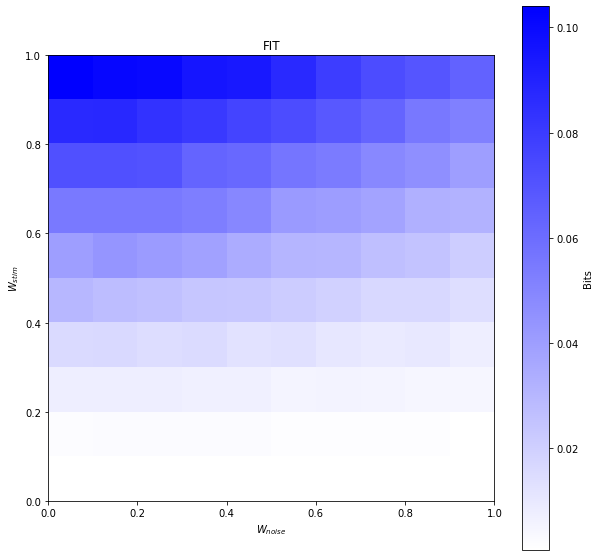

In [44]:
plt.figure(figsize=(10, 10))
# Display the matrix using imshow.
# 'extent' sets the axes limits and 'origin' ensures y=0 is at the bottom.
white_blue = LinearSegmentedColormap.from_list("white_blue", ["white", "blue"])
plt.imshow(np.mean(fit, axis=0), extent=[0, 1, 0, 1], origin='lower', cmap=white_blue)
plt.colorbar(label='Bits')
plt.xlabel('$W_{noise}$')
plt.ylabel('$W_{stim}$')
plt.title('FIT')
plt.show()

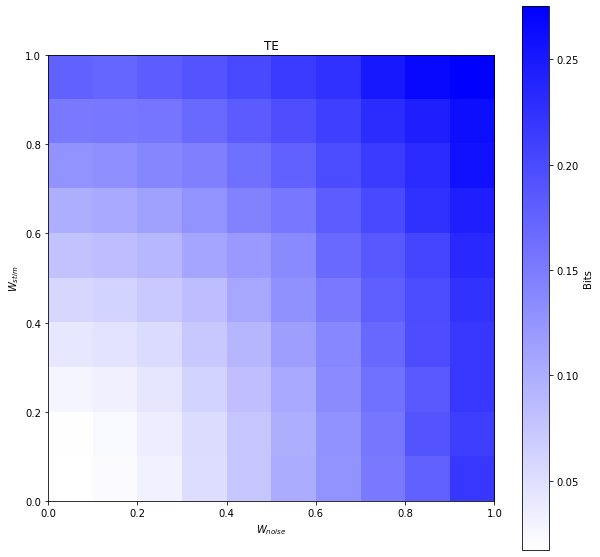

In [45]:
plt.figure(figsize=(10, 10))
# Display the matrix using imshow.
# 'extent' sets the axes limits and 'origin' ensures y=0 is at the bottom.
white_blue = LinearSegmentedColormap.from_list("white_blue", ["white", "blue"])
plt.imshow(np.mean(te, axis=0), extent=[0, 1, 0, 1], origin='lower', cmap=white_blue)
plt.colorbar(label='Bits')
plt.xlabel('$W_{noise}$')
plt.ylabel('$W_{stim}$')
plt.title('TE')
plt.show()